# Time Dependent Schrödinger's Equation

## Development

### Schrödinger's Equation

Shrödinger's Equation reads:

$i\hbar\,\frac{\partial\psi}{\partial t}=\frac{-\hbar^2}{2m}\,\frac{\partial^2\psi}{\partial x^2}+V\cdot\psi$

The goal of this program is to numerically solve this equation.

___

### Finite Difference Method

Given a function $f(x)$ we can expand $f(x+\Delta x)$ through a Taylor Series expantion about x:

$\textstyle f(x+\Delta x) = f(x) + \Delta x\cdot f'(x) + \mathcal{O}(\Delta x^2)$

so we can define the **first forward finite difference** as:

$f'_+\approx \frac{f(x + \Delta x)-f(x)}{\Delta x}$

similarly, by expanding $f(x-\Delta x)$, we define de **first backwards finite difference**:

$f'_-\approx \frac{f(x)-f(x - \Delta x)}{\Delta x}$

from this we can approximate the second derivative $f''(x)$ by:

$f''(x) \approx \frac{f'_+(x)-f'_-(x)}{\Delta x} = \frac{\frac{f(x + \Delta x)-f(x)}{\Delta x}-\frac{f(x)-f(x - \Delta x)}{\Delta x}}{\Delta x} = \frac{f(x+\Delta x)-2\cdot f(x) + f(x-\Delta x)}{\Delta x^2}$

___

### Numerical Solution to Schrödinger's Equation

If the particle is contained within a finite region of lenght $L$, we can subdivide the region on $N_x$ subitnervals of lenght $\Delta x = \frac{L}{N}$, such that we define the points:

$0,\,\Delta x,\,2\cdot\Delta x,\,3\cdot\Delta x,\,\dots,\,(N_x-1)\cdot\Delta x,\,L$

or

$\displaystyle x_0,\,x_1,\,x_2,\,\dots,\,x_{N_x-1},\,x_{N_x}$

Similarlly, if we are interested in the evolution of the particle in the time interval from $t_0$ to $t_f$, by dividing the interval in $N_t$ steps, we get a step size of $\Delta t = \frac{t_f-t_0}{N_t}$. Thus, we would have the set of time points:

$t_0,\,t_0+\Delta t,\,t_0+2\Delta t,\,t_0+3\Delta t,\dots,\,t_0+(N_t-1)\Delta t,\,t_f$

or

$\displaystyle t_0,\,t_1,\,t_2,\,\dots,\,t_{N_t-1},\,t_{N_t}$

TBy employing finite differences, and defining $\psi_{i,j} := \psi(x_i,t_j)$, Schrödinger's Equation can be written as:

$\displaystyle i\hbar \left(\frac{\psi_{i,j+1}-\psi_{i,j}}{\Delta t}\right) = \frac{-\hbar^2}{2m}\left(\frac{\psi_{i+1,j}-2\cdot\psi_{i,j}+\psi_{i-1,j}}{\Delta x^2}\right) + V_{i,j}\cdot\psi_{i,j}$

so that we can write the following requrance relation:

$\displaystyle \psi_{i,j+1} = \frac{\Delta t}{i\hbar}\left[\frac{-\hbar^2}{2m}\left(\frac{\psi_{i+1,j}-2\cdot\psi_{i,j}+\psi_{i-1,j}}{\Delta x^2}\right) + V_{i,j}\cdot\psi_{i,j}\right]+\psi_{i,j}$

Thus, given a defined initial state $\psi_{i,0}$ with $(0\leq i \leq N_x)$, we can employ the recurrance relation to calculate the state at an arbitrary subsequent time. The initial state we will employ is the result of the time-independent code.

___
___


## Code

### Setup

**Importing Libraries**

In [80]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate as integrate

**Physical Constants**

In [81]:
hbar = 1  # reduced plank's constant
m = 1     # particle's mass

**Problem Parameters**

In [82]:
final_t = 300
steps = 500001#500001

In [83]:
phis = np.load("ti_wf.npy",allow_pickle=True)                   # importing the results of the time-independent program
xs = phis.item().get("xs")                                      # defining the spacial evaluation points
ts = np.linspace(0, final_t, steps,dtype=np.float64)            # defining the time evaluation points

a = xs[0]                                                       # lower space bound
b = xs[-1]                                                      # upper space bound

Nx = xs.shape[0]                                                # number of space intervals
Nt = ts.shape[0]                                                # number of time intervals

dx = xs[1]-xs[0]                                                # spacial step size
dt = ts[1]-ts[0]                                                # time step size

**Potential**

In [84]:
# Definition of the potential function

def potential(x,t):
    k = 1/10
    P = 0
    # if (a) < x < (b):
    #     P += 0
    # else:
    #     P += 1e20
    P += np.exp(-(x/k)**2)*np.exp(-((t-1)/k)**2, dtype=np.complex256)
    return 0

potential(1,0)

0

### Finite Difference Method

**Potential Energy**

In [85]:
V = np.zeros_like(np.outer(xs,ts), dtype=np.complex256)

for i,row in enumerate(V):
    for j,col in enumerate(row):
        V[i,j] = potential(xs[i],ts[j])

**Algorithm**

In [86]:
wfs = np.zeros(2,dtype=object)

for k,w in enumerate(wfs):
    wf =pd.DataFrame(index=ts,columns=xs)
    phi1 =(phis.item().get(k)).astype(np.complex256)
    for j in range(Nt):
        if j == 0:
            wf.iloc[0] = phi1
        else:
            phi2 = np.zeros_like(phi1, dtype=np.complex256)
            for i,val in enumerate(phi2):
                if (i==0) or (i >= (Nx-1)):
                    phi2[i] = 0
                else:
                    phi2[i] = dt/(1j*hbar)*(-hbar**2/(2*m*dx**2)*(phi1[i+1]-2*phi1[i]+phi1[i-1])+V[i,j]*phi1[i]) + phi1[i]
            norm = integrate.simpson((phi2*np.conj(phi2)).real,xs)
            phi2 = phi2/np.sqrt(norm)
            wf.iloc[j] = phi2
            phi1 = phi2          
    wfs[k] = wf


: 

: 

In [ ]:
pcs = np.zeros(2,dtype=object)

for k,w in enumerate(pcs):
    pc = pd.DataFrame(index=ts,columns=xs)
    for i in range (Nt):
        phi = wfs[k].iloc[i].to_numpy()
        cur = np.zeros_like(phi)
        for j, row in enumerate(cur):
            if (j == 0) or (j == (Nx-1)):
                cur[j] = 0
            else:
                cur[j] = ((hbar/m)*(np.conj(phi[j])/1j*(phi[j+1] - phi[j-1])/(dx**2))).real
        pc.iloc[i] = cur
    pcs[k] = pc

### Animation

**Animation Function**

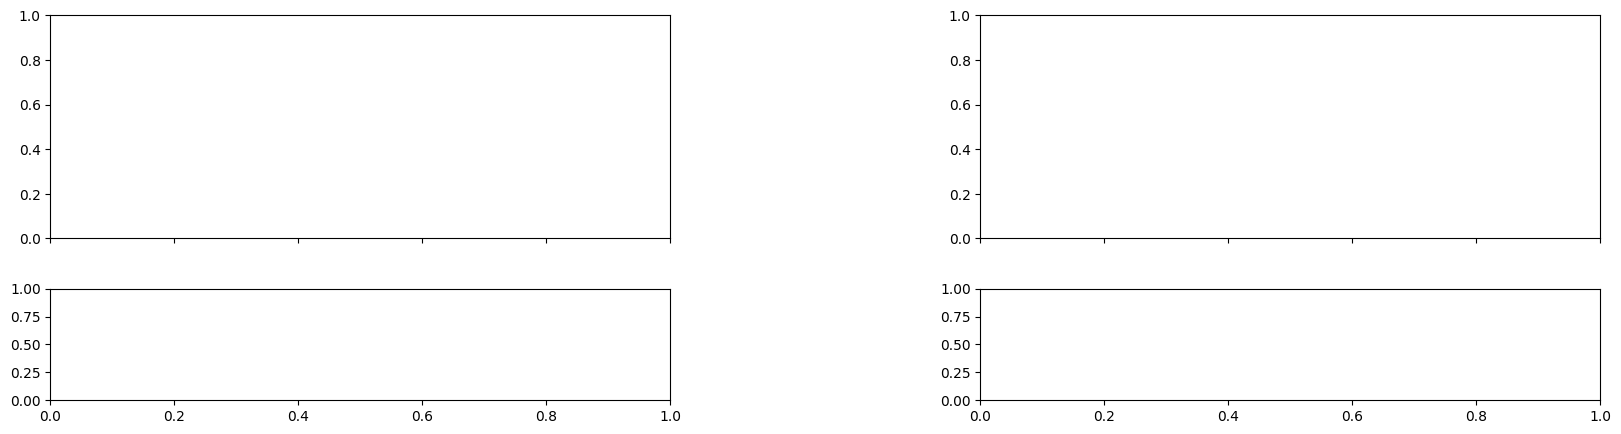

In [ ]:
fr = 101

plt.rcParams['animation.embed_limit'] = 2**128

figure, ax1 = plt.subplots(2,2,figsize = (20,5),sharex=True, gridspec_kw={'height_ratios':[2,1]})
plt.subplots_adjust(wspace= 0.5,hspace=0.3)

def aniFunc(t):
    for i,row in enumerate(ax1):
        for j,col in enumerate(row):
            if i == 0:
                ax1[0,j].clear()
                a = wfs[j].iloc[int(t*Nt/fr)].to_numpy()
                b = (a*np.conj(a)).astype(np.complex256).real
                ax1[0,j].plot(xs,b,color='C0')
                ax1[0,j].plot(xs,V[:,int(t*Nt/fr)].real,color='C1')
                ax1[0,j].grid()
                ax1[0,j].set_xlim([-11,11])
                ax1[0,j].set_ylim([-0.01,0.15])
                ax1[0,j].set_title(r'$E_{}$'.format(j+1))
            else:
                c = pcs[j].iloc[int(t*Nt/fr)].to_numpy()
                ax1[1,j].clear()
                ax1[1,j].plot(xs,c,color='C2')
                ax1[1,j].grid()
                ax1[1,j].set_xlim([-11,11])
                ax1[1,j].set_ylim([-2,2])
    leg = figure.legend(['$|\Psi|^2$',' V',' J'],fontsize=15,loc='upper left')
    leg.legendHandles[0].set_color('C0')
    leg.legendHandles[1].set_color('C1')
    leg.legendHandles[2].set_color('C2')
    figure.suptitle(r't = {0:.3f}'.format(np.round(ts[int(t*Nt/fr)],3)),fontsize=20)
    figure.subplots_adjust(top=0.75)
    # ax1[1].set_xlabel(r'$x$')
    # # ax1[1].suptitle(r'$E_4$')
    # # ax1[1].title(r't = {0:.3f}'.format(np.round(ts[int(i*Nt/fr)],3)))
    # # ax1[1].legend(['$|\Psi|^2$','J','V'])
    # ax1[0].grid()



**Generate Animation**

In [ ]:
anim = animation.FuncAnimation(figure, func=aniFunc,frames=fr,interval=1)

# from IPython.display import HTML
# HTML(anim.to_jshtml())
writervideo = animation.FFMpegWriter(fps=160)
anim.save('E1.mp4', writer=writervideo)

/tmp/ipykernel_1028/3048589592.py:29: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color('C0')
/tmp/ipykernel_1028/3048589592.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('C1')
/tmp/ipykernel_1028/3048589592.py:31: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color('C2')
